# Демонстрация. CUPED и CUPAC

In [2]:
import numpy as np
import pandas as pd
from typing import Optional, List
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from operator import attrgetter
from scipy.stats import ttest_ind, pearsonr, gamma
import random

### 1. Описание данных:

**Таргет**: ARPU = Average Revenue Per User

**Признаки**:  
- Признак тарифа с абонентской платой (month_fee_flag)
- Количество дней с активным траффиком в месяц (act_traffic_days_cnt)
- Длительность пребывания клиента в компании (lifetime)

### 2. Генерация переменных

In [6]:
# ARPU за предыдущий месяц
arpu_prev = np.random.gamma(2, 4, 10000) * 20

# ARPU за текущий месяц
arpu_now =  0.5 * arpu_prev + np.random.gamma(2, 5, 10000) * 5

# Длительность пребывания клинента в компании (кол-во месяцев)
lifetime_cnt_prev = np.round(0.05 * arpu_prev + 2 + np.random.gamma(2, 4, 10000))
lifetime_cnt_now = np.round(0.05 * arpu_prev + 2 + np.random.gamma(2, 4, 10000)) + 1

# Признак тарифа с абонентской платой
month_fee_flag_prev = np.sign(0.05 * arpu_prev + np.random.normal(2, 6, 10000))
month_fee_flag_now = month_fee_flag_prev 

# Количество дней с активным трафиком в месяц
traffic_days_cnt_prev = np.round(0.03 * arpu_prev + 2 + np.random.gamma(1, 2, 10000))
traffic_days_cnt_prev = np.where(traffic_days_cnt_prev > 31, 31, traffic_days_cnt_prev)

traffic_days_cnt_now = np.round(0.7 * traffic_days_cnt_prev + np.random.gamma(1, 2, 10000))
traffic_days_cnt_now = np.where(traffic_days_cnt_now > 31, 31, traffic_days_cnt_now)

# Признак попадания в тестовую группу
treat_flag = np.sign(np.random.normal(0, 0.5, 10000))
treat_flag = np.where(treat_flag == -1, 0, treat_flag)

In [7]:
print('Корреляция ARPU за текущий и предыдущий месяц: ', np.round(pearsonr(arpu_prev, arpu_now)[0], 3))
print('Корреляция ARPU и фичи Длительность пребывания клиента в компании: ', np.round(pearsonr(lifetime_cnt_prev, arpu_now)[0], 3))
print('Корреляция ARPU и фичи Признак тарифа с абонентской платой: ', np.round(pearsonr(month_fee_flag_prev, arpu_now)[0], 3))
print('Корреляция ARPU и фичи Количество дней с активным траффиком в месяц: ', np.round(pearsonr(traffic_days_cnt_prev, arpu_now)[0], 3))

Корреляция ARPU за текущий и предыдущий месяц:  0.847
Корреляция ARPU и фичи Длительность пребывания клиента в компании:  0.586
Корреляция ARPU и фичи Признак тарифа с абонентской платой:  0.216
Корреляция ARPU и фичи Количество дней с активным траффиком в месяц:  0.726


In [8]:
# Объединяем данные в один датасет
df = pd.DataFrame({'lifetime_cnt_now': lifetime_cnt_now, 
                   'lifetime_cnt_prev': lifetime_cnt_prev, 
                   'month_fee_flag_now': month_fee_flag_now,
                   'month_fee_flag_prev': month_fee_flag_prev, 
                   'traffic_days_cnt_now':traffic_days_cnt_now, 
                   'traffic_days_cnt_prev':traffic_days_cnt_prev,
                   'arpu_prev': arpu_prev, 
                   'arpu_now':arpu_now,
                   'treat_flag': treat_flag})

In [9]:
df.head()

,lifetime_cnt_now,lifetime_cnt_prev,month_fee_flag_now,month_fee_flag_prev,traffic_days_cnt_now,traffic_days_cnt_prev,arpu_prev,arpu_now,treat_flag
0,21.0,15.0,1.0,1.0,5.0,6.0,72.757065,94.816434,0.0
1,19.0,22.0,1.0,1.0,8.0,12.0,178.639084,157.629495,1.0
2,24.0,23.0,1.0,1.0,10.0,10.0,277.361669,174.858576,1.0
3,13.0,11.0,1.0,1.0,6.0,5.0,69.248770,91.386159,1.0
4,26.0,8.0,1.0,1.0,6.0,5.0,70.247087,117.104994,1.0


### 3. CUPED

Построим метрику CUPED для целевой переменной (ARPU за текущий месяц) с использованием разных ковариат.

In [12]:
def cuped(df, target, groups, covariate):
    X = df.copy()

    cov = X[[target, covariate]].cov().loc[target, covariate]
    var = X[covariate].var()
    theta = cov / var

    for group in X[groups].unique():
        X_subdf = X[X[groups] == group]
        group_y_cuped = X_subdf[target] - theta * (X_subdf[covariate] - X_subdf[covariate].mean())
        X.loc[X[groups] == group, target] = group_y_cuped

    return X

#### 3.1. Ковариата - ARPU за предыдущий месяц

In [20]:
target = 'arpu_now'
covariate = 'arpu_prev'
groups = 'treat_flag'

In [22]:
df_cuped_1 = cuped(df, target, groups, covariate)

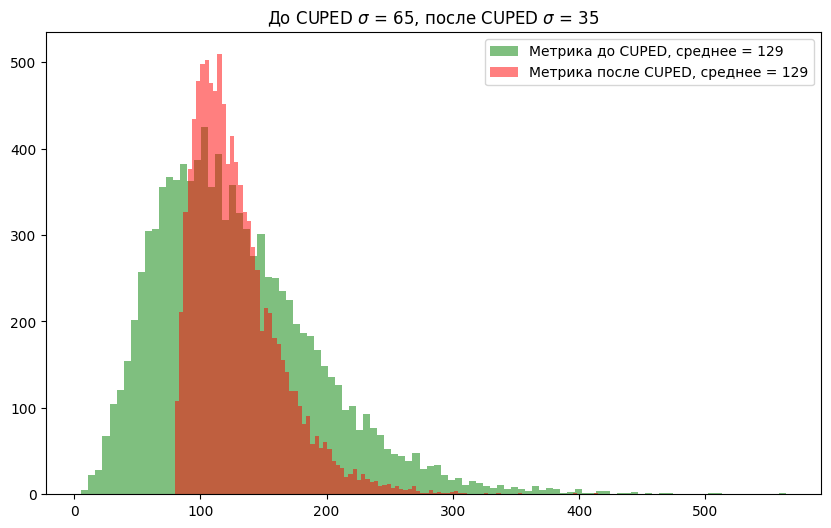

In [24]:
std_bef_cuped =  round(df['arpu_now'].std())
std_cuped = round(df_cuped_1['arpu_now'].std())
mean_bef_cuped =  round(df['arpu_now'].mean())
mean_cuped = round(df_cuped_1['arpu_now'].mean())

fig, ax = plt.subplots()
plt.hist(df['arpu_now'], alpha = 0.5, label = f'Метрика до CUPED, среднее = {mean_bef_cuped}', color = 'green', bins = 100)
plt.hist(df_cuped_1['arpu_now'], alpha = 0.5, label = f'Метрика после CUPED, среднее = {mean_cuped}', color = 'red', bins = 100)
fig.set_figheight(6)
fig.set_figwidth(10)
ax.legend()
ax.set_title(f'До CUPED $\\sigma$ = {std_bef_cuped}, после CUPED $\\sigma$ = {std_cuped}')
plt.show()

#### 3.2. Ковариата - Длительность пребывания клиента в компании

In [27]:
target = 'arpu_now'
covariate = 'lifetime_cnt_prev'
groups = 'treat_flag'

In [29]:
df_cuped_2 = cuped(df, target, groups, covariate)

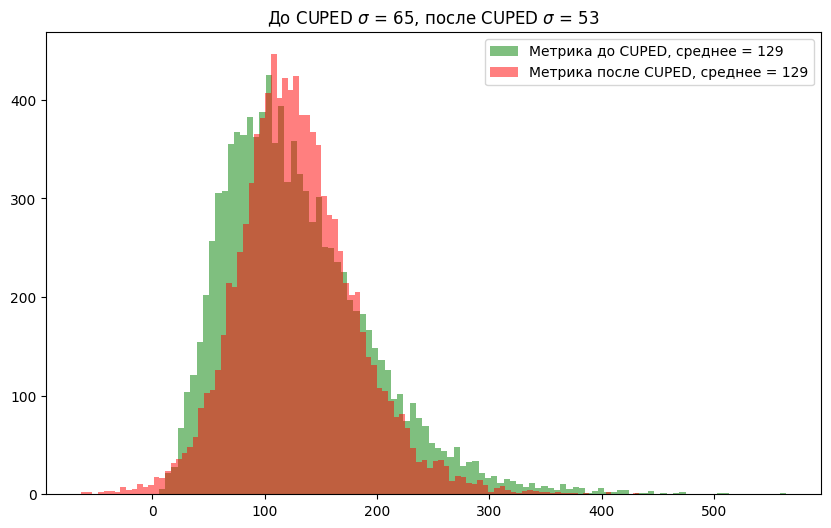

In [31]:
std_cuped = round(df_cuped_2['arpu_now'].std())
mean_cuped = round(df_cuped_2['arpu_now'].mean())

fig, ax = plt.subplots()
plt.hist(df['arpu_now'], alpha = 0.5, label = f'Метрика до CUPED, среднее = {mean_bef_cuped}', color = 'green', bins = 100)
plt.hist(df_cuped_2['arpu_now'], alpha = 0.5, label = f'Метрика после CUPED, среднее = {mean_cuped}',color = 'red',  bins = 100)

fig.set_figheight(6)
fig.set_figwidth(10)
ax.legend()
ax.set_title(f'До CUPED $\\sigma$ = {std_bef_cuped}, после CUPED $\\sigma$ = {std_cuped}')
plt.show()

#### 3.3 Ковариата - Количество дней с активным траффиком в месяц

In [34]:
target = 'arpu_now'
covariate = 'traffic_days_cnt_prev'
groups = 'treat_flag'

In [36]:
df_cuped_3 = cuped(df, target, groups, covariate)

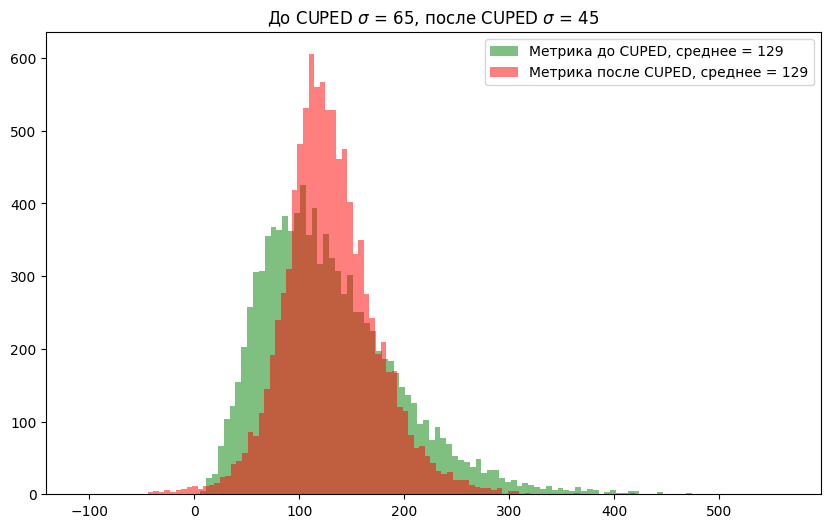

In [38]:
std_cuped = round(df_cuped_3['arpu_now'].std())
mean_cuped = round(df_cuped_3['arpu_now'].mean())

fig, ax = plt.subplots()
plt.hist(df['arpu_now'], alpha = 0.5, label = f'Метрика до CUPED, среднее = {mean_bef_cuped}', color = 'green', bins = 100)
plt.hist(df_cuped_3['arpu_now'], alpha = 0.5, label = f'Метрика после CUPED, среднее = {mean_cuped}', color = 'red', bins = 100)
fig.set_figheight(6)
fig.set_figwidth(10)
ax.legend()
ax.set_title(f'До CUPED $\\sigma$ = {std_bef_cuped}, после CUPED $\\sigma$ = {std_cuped}')
plt.show()

Вывод: лучше всего сократила дисперсию ковариата - ARPU за предыдущий месяц (наиболее коррелирующая фича с целевой переменной)

### 4. CUPAC

Построим метрику CUPAC для целевой переменной (ARPU за текущий месяц) с использованием разных ковариат.

In [43]:
def predict_target(X, target_prev, factors_prev, factors_now):
    Y = X[target_prev]
    X_train = X[factors_prev]
    model = sm.OLS(Y, X_train)

    results = model.fit()
    print(results.summary())
    X_predict = X[factors_now]

    return results.predict(X_predict)

In [45]:
def cupac(X, target_prev, target_now, factors_prev, factors_now, groups):
    X.loc[:, 'target_pred'] = predict_target(X, target_prev, factors_prev, factors_now)
    X_new = cuped(X, target_now, groups, 'target_pred')

    return X_new

In [47]:
target_prev = 'arpu_prev'
target_now = 'arpu_now'
factors_prev = ['lifetime_cnt_prev', 'traffic_days_cnt_prev', 'month_fee_flag_prev']
factors_now = ['lifetime_cnt_now', 'traffic_days_cnt_now', 'month_fee_flag_now']

In [49]:
df_cupac = cupac(df, target_prev, target_now, factors_prev, factors_now, groups)

                                 OLS Regression Results                                
Dep. Variable:              arpu_prev   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                          3.192e+04
Date:                Sat, 23 Nov 2024   Prob (F-statistic):                        0.00
Time:                        13:13:12   Log-Likelihood:                         -55043.
No. Observations:               10000   AIC:                                  1.101e+05
Df Residuals:                    9997   BIC:                                  1.101e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

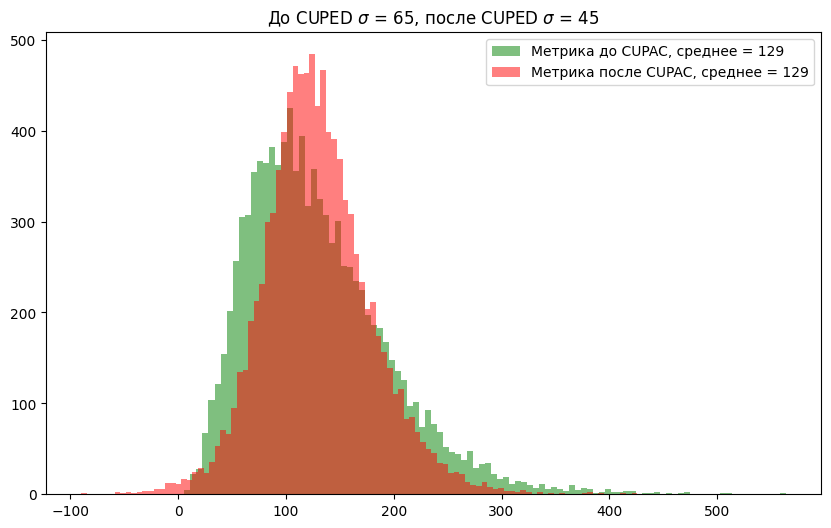

In [51]:
std_bef_cupac =  round(df['arpu_now'].std())
std_cupac = round(df_cupac['arpu_now'].std())
mean_bef_cupac =  round(df['arpu_now'].mean())
mean_cupac = round(df_cupac['arpu_now'].mean())

fig, ax = plt.subplots()
plt.hist(df['arpu_now'], alpha = 0.5, label = f'Метрика до CUPAC, среднее = {mean_bef_cupac}', color = 'green', bins =100)
plt.hist(df_cupac['arpu_now'], alpha =  0.5, label = f'Метрика после CUPAC, среднее = {mean_cupac}', color = 'red', bins =100)
fig.set_figheight(6)
fig.set_figwidth(10)
ax.legend()
ax.set_title(f'До CUPED $\\sigma$ = {std_bef_cuped}, после CUPED $\\sigma$ = {std_cuped}')
plt.show()